# <span style="font-family: 'Computer Modern'; font-size: 42pt; font-weight: bold;">Quantum Convolutional Neural Network (QCNN): *Laboratory of Particle Physics and Cosmology (LPPC)*</span>

In [ ]:
## Note:
## This notebook utilizes a Python package derived from the successful construction efforts with 'QCNN_Copy.ipynb'.
## It demonstrates a functional implementation of the QCNN with PennyLane using updated and modularized package code.

In [1]:
#### ***** IMPORTS / DEPENDENCIES *****:

### *** PLOTTING ***:
import matplotlib.pyplot as plt

### *** PENNYLANE ***:
import pennylane as qml
from pennylane import numpy as np

### *** DATA ***:
import numpy as np
import seaborn as sns
sns.set()

### *** JAX ***:
import jax;
## JAX CONFIGURATIONS:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

### *** Random Number Generators (RNGs) ***:
seed = 0
rng_type = "jax" # Select rng for data processing (qcnn uses jax rng with 'PRNGKey')
# ------------------------------------------------------------------------------------
if rng_type == "jax":
    rng_jax = jax.random.PRNGKey(seed=seed) # Base (JAX)
    rng_jax_arr = jnp.array(rng_jax) # Base as array (JAX)
    print(f"RNG Package Type: {type(rng_jax)}") # Confirm JAX rng selection 
else:
    rng = np.random.default_rng(seed=seed) # Base (NP)
    print(f"RNG Package Type: {type(rng)}")  # Confirm NumPy rng selection
# ------------------------------------------------------------------------------------

RNG Package Type: <class 'jaxlib.xla_extension.ArrayImpl'>


In [2]:
#### ***** PACKAGE IMPORT EXAMPLES *****:
# *****************************************************************************************
## *1* MNIST DATA LOADING CLASS:
# from lppc_qcnn.load_qc_data import LoadDataQC # LoadDataQC() <--- STATIC METHOD

## *1* QCNN DATA ANALYSIS CLASS:
# from lppc_qcnn.load_qc_data import DataQCNN # DataQCNN() <--- STATIC METHOD

## *2* QUANTUM CIRCUIT AND LAYERS CLASS:
# from lppc_qcnn.circuit_layers import LayersQC # LayersQC() <--- INSTANCE METHOD (SELF)
# -> Define Instance of LayersQC:
# layers_obj = LayersQC()

## *3* TRAIN QCNN / RESULTS CLASS:
# from lppc_qcnn.circuit_layers import TrainQC # <--- STATIC METHOD
# -> Define Instance of TrainQC:
# layers_obj = TrainQC()

## *4* QUANTUM AND MATH OPERATORS CLASS:
# from lppc_qcnn.qc_operators import QuantumMathOps # <--- STATIC METHOD
# *****************************************************************************************

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">LOADING MNIST DATASET</span>

In [3]:
# ********************************************
#           INITIAL PARAMETER SETUP
# ********************************************

## IMPORT MNIST DATA LOADING CLASS:
from lppc_qcnn.load_qc_data import LoadDataQC # <--- STATIC METHOD

## *** DEFINE VARIABLES (QUBITS) ***:
# =======================================================
n_qubits = 6 # Number of qubits (six-qubit device)
active_qubits = list(range(n_qubits))  # Active qubits
num_wires = 6 # Number of wires
# =======================================================

## QUANTUM DEVICE:
# Select quantum device for QCNN (currently uses jax device for optimization):
device_type = "jax" # "jax" -> # JAX-based device, "mixed" -> MIXED-state device, "default" -> BASIC qubit device
if device_type == "jax":
    device = qml.device('default.qubit.jax', wires=num_wires)
elif device_type == "mixed":
    device = qml.device("default.mixed", wires=num_wires)
else:
    device = qml.device("default.qubit", wires=num_wires)
print(f"Selected device: {device.short_name}") # Confirm device selection

Selected device: default.qubit.jax


<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 14pt;">Data Analysis / Testing (JAX):</span>

In [4]:
## IMPORT QCNN DATA ANALYSIS CLASS:
from lppc_qcnn.load_qc_data import DataQCNN # <--- STATIC METHOD

## ASSESS DATA STRUCTURES (NP VS. JAX):
DataQCNN.dataset_structure(package='numpy') # Data attributes if using NumPy
# JAX Attributes:
DataQCNN.dataset_structure(package='jax') # Data attributes if using JAX

------------NUMPY------------
___Shape+Type___:
• FEATURES type:  <class 'numpy.ndarray'>  | shape:  (1797, 64)
• LABELS type:  <class 'numpy.ndarray'>  | shape:  (1797,)
___DataType___:
• FEATURES dtype:  float64  | class type:  <class 'numpy.ndarray'>
• LABELS dtype:  int64  | class type:  <class 'numpy.int64'>
___SIZE___:
• FEATURES size:  115008
• LABELS size:  1797


------------JAX------------
___Shape+Type___:
• FEATURES type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (1797, 64)
• LABELS type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (1797,)
___DataType___:
• FEATURES dtype:  float64  | class type:  <class 'jaxlib.xla_extension.ArrayImpl'>
• LABELS dtype:  int64  | class type:  <class 'jaxlib.xla_extension.ArrayImpl'>
___SIZE___:
• FEATURES size:  115008
• LABELS size:  1797



In [5]:
# ********************************************
#          LOADING THE MNIST DATASET
# ********************************************

## *** DEFINE VARIABLES (DATA/IMAGES) ***:
# =======================================================
n_train_data = 2 # Number of TRAIN images for data
n_test_data = 2 # Number of TRAIN images for data
# =======================================================

# Prepare data by completing NumPy operators before casting with JAX:
features_np, labels_np = LoadDataQC.prepare_data()

# Convert to JAX arrays
features = jnp.array(features_np)
labels = jnp.array(labels_np)

## JAX.JIT CONFIGURATION:
# ------------------------------------------------------------------------------------------------------
use_wrapped_version = False  # TRUE -> jax.jit-wrapped version, FALSE -> direct call

if use_wrapped_version is True:
    # Load data using wrapped function:
    load_digits_data_jax_wrapped = jax.jit(LoadDataQC.load_digits_data_jax)
    x_train, y_train, x_test, y_test = load_digits_data_jax_wrapped(n_train_data, n_test_data,
                                                                    features, labels)
else:
    # Load JAX data directly:
    x_train, y_train, x_test, y_test = LoadDataQC.load_digits_data_jax(n_train=n_train_data,
                                                n_test=n_test_data, features=features, labels=labels)
# ------------------------------------------------------------------------------------------------------

##                        ***** FUNCTIONALITY CHECK (DATA) *****
# -----------------------------------------------------------------------------------------
print(f"{'='*15} FUNCTIONALITY CHECK (DATA) {'='*15}")

# Shapes and Types:
print(f"\n{'='*14} (1) SHAPES AND TYPES {'='*14}")
print(f"• x_train type:  {type(x_train)}  | shape:  {x_train.shape}")
print(f"• y_train type:  {type(y_train)}  | shape:  {y_train.shape}")
print(f"• x_test type:  {type(x_test)}  | shape:  {x_test.shape}")
print(f"• y_test type:  {type(y_test)}  | shape:  {y_test.shape}")

# Normalization:
print(f"\n{'='*10} (2) NORMALIZATION {'='*10}")
print(f"• x_train first row norm:  {jnp.linalg.norm(x_train[0])}") # (JAX)
print(f"• x_test first row norm:  {jnp.linalg.norm(x_test[0])}") # (JAX)

# Label Uniqueness:
print(f"\n{'='*10} (3) LABEL UNIQUENESS {'='*10}")
print(f"• Unique labels -> y_train:  {jnp.unique(y_train, size=2, fill_value=1)}") # (JAX)
print(f"• Unique labels -> y_test:  {jnp.unique(y_test, size=2, fill_value=1)}") # (JAX)
# -----------------------------------------------------------------------------------------

=============== FUNCTIONALITY CHECK (DATA) ===============

============== (1) SHAPES AND TYPES ==============
• x_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)
• x_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)

========== (2) NORMALIZATION ==========
• x_train first row norm:  0.9999999999999999
• x_test first row norm:  0.9999999999999999

========== (3) LABEL UNIQUENESS ==========
• Unique labels -> y_train:  [0 1]
• Unique labels -> y_test:  [0 1]


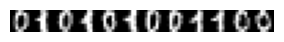

In [6]:
# ********************************************
#        VISUALIZING THE MNIST DATASET
# ********************************************

## DRAW MNIST IMAGE:
LoadDataQC.draw_mnist_data()

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CONSTRUCTING QUANTUM CIRCUIT</span>

/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/pennylane/drawer/mpldrawer.py:581: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  bbox = text_obj.get_window_extent(renderer)


*** QCNN QUANTUM CIRCUIT ***


/Users/seanchisholm/VSCode_LPPC/qcnn-lppc/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


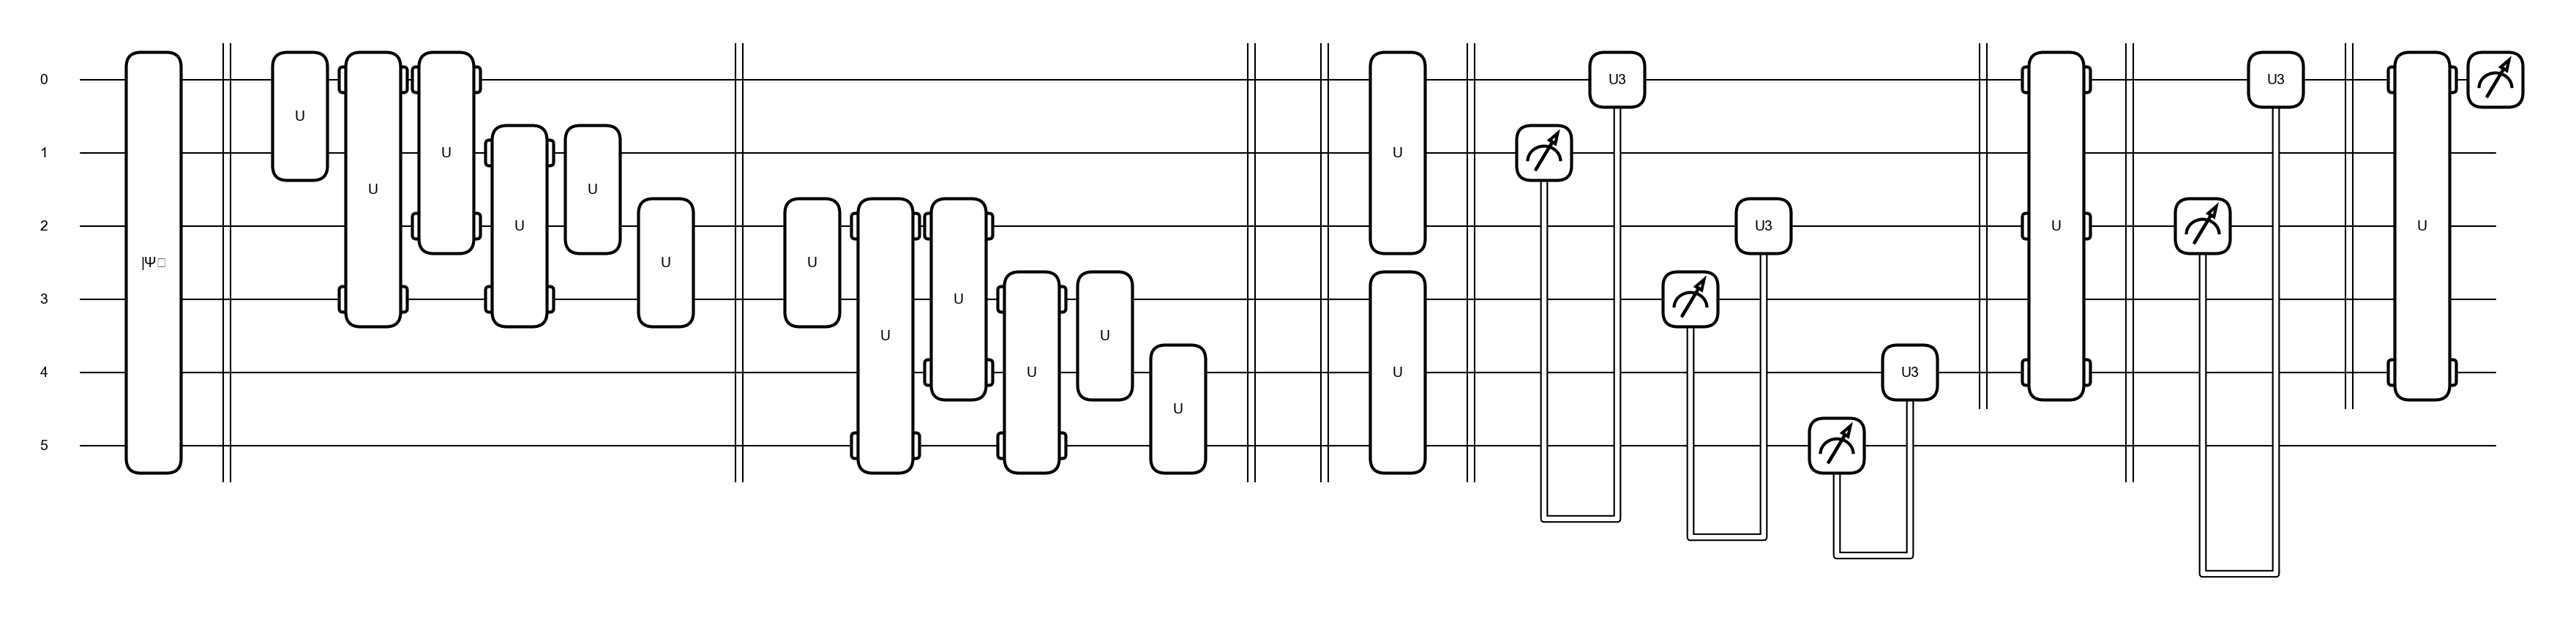

In [7]:
# ********************************************
#    VISUALIZING / PLOTTING QUANTUM CIRCUIT
# ********************************************

## IMPORT QUANTUM CIRCUIT AND LAYERS CLASS:
from lppc_qcnn.circuit_layers import LayersQC # <--- INSTANCE METHOD (SELF)
layers_obj = LayersQC()

## DEFINE SAMPLE WEIGHTS / FEATURES FOR CONV_NET:
num_wires_draw = 6 # Number of wires (DRAWINGS)
weights = np.random.rand(81, 2) # <-- Shape ~ [(num_wires // 2) * (3 ** 3)]
last_layer_weights = np.random.rand(4 ** 2 - 1)
features = np.random.rand(2 ** num_wires_draw)

## DRAW QUANTUM CIRCUIT:
fig, ax = qml.draw_mpl(layers_obj.conv_net)(
layers_obj, weights, last_layer_weights, features
)

print("*** QCNN QUANTUM CIRCUIT ***")
plt.show()

*** QCNN CONVOLUTIONAL LAYER CIRCUIT ***


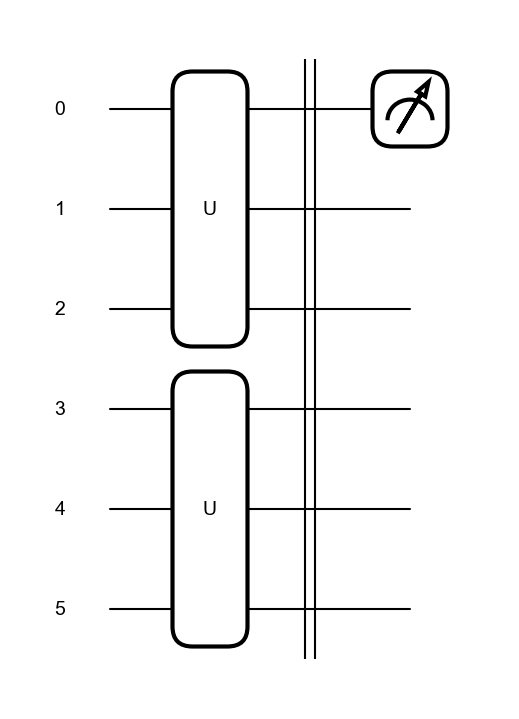

In [8]:
# ********************************************
#     VISUALIZING / PLOTTING CONV CIRCUIT
# ********************************************

## DEFINE SAMPLE WEIGHTS / FEATURES FOR THREE_LAYER_CONV:
n_qubits_draw = 6  # Number of qubits
active_qubits_draw = list(range(n_qubits_draw))  # Active qubits
params_draw = weights[:, 0]  # (Note: Use appropriate slicing based on drawing needs)

## DRAW CONVOLUTIONAL LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.three_layer_conv_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print("*** QCNN CONVOLUTIONAL LAYER CIRCUIT ***")
plt.show()

*** QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT ***


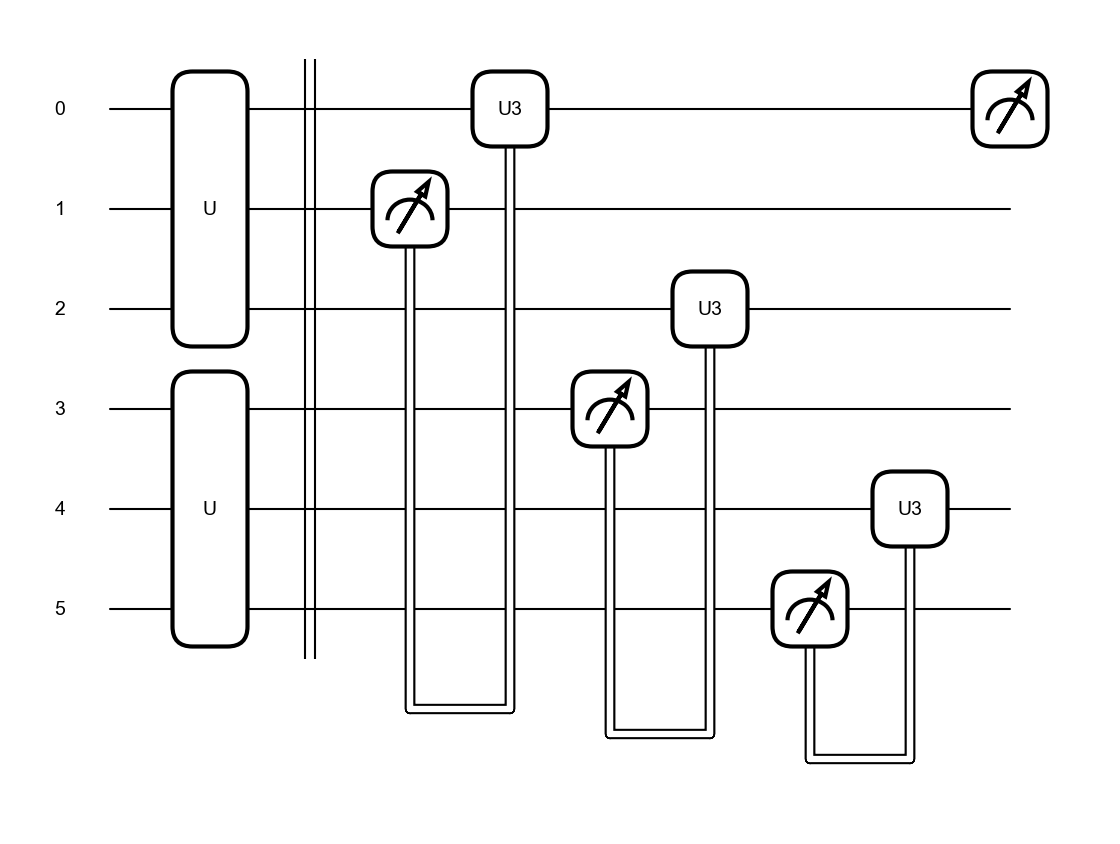

In [9]:
# ********************************************
#     VISUALIZING CONV AND POOLING CIRCUIT
# ********************************************

## DRAW CONVOLUTIONAL AND POOLING LAYER (CIRCUIT):
fig, ax = qml.draw_mpl(layers_obj.conv_and_pooling_circuit)(
layers_obj, params_draw, active_qubits_draw
)

print("*** QCNN CONVOLUTIONAL AND POOLING LAYER CIRCUIT ***")
plt.show()

In [10]:
# ********************************************
#           TRAINING QCNN / RESULTS
# ********************************************

## IMPORT TRAINING QCNN CLASS:
from lppc_qcnn.circuit_layers import TrainQC  # TrainQC() <--- STATIC METHOD (WITH JAX)

## *** DEFINE VARIABLES (TRAINING) ***:
# =======================================================
n_train = 5
n_test = 10
n_epochs = 100
n_reps = 10
# =======================================================

# TRAIN QCNN -> RESULTS:
results_df = TrainQC.compute_aggregated_results(n_train=n_train, n_test=n_test, n_epochs=n_epochs, n_reps=n_reps)

In [11]:
##         ***** FUNCTIONALITY CHECK (TRAINING) *****
# -----------------------------------------------------------------------------------------
indices = list(range(99, 1000, 100)) # indices for every 100th step (starting from 0)
indices.insert(0, 0) # Add zero to beginning of list

# Use indices to filter DataFrame:
filtered_df = results_df.iloc[indices]
## PRINT:
print(f"\n{'='*31} QCNN RESULTS {'='*31}\n")
print(filtered_df)
# -----------------------------------------------------------------------------------------


=============================== QCNN RESULTS ===============================

    train_acc           train_cost test_acc            test_cost step n_train
0         1.0   0.5197587069525987      1.0   0.4479928408386441    1       5
99        1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
199       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
299       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
399       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
499       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
599       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
699       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
799       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
899       1.0  0.15474609361146335      1.0  0.21281487522827447  100       5
999       1.0  0.15474609361146335      1.0  0.2128148752282744

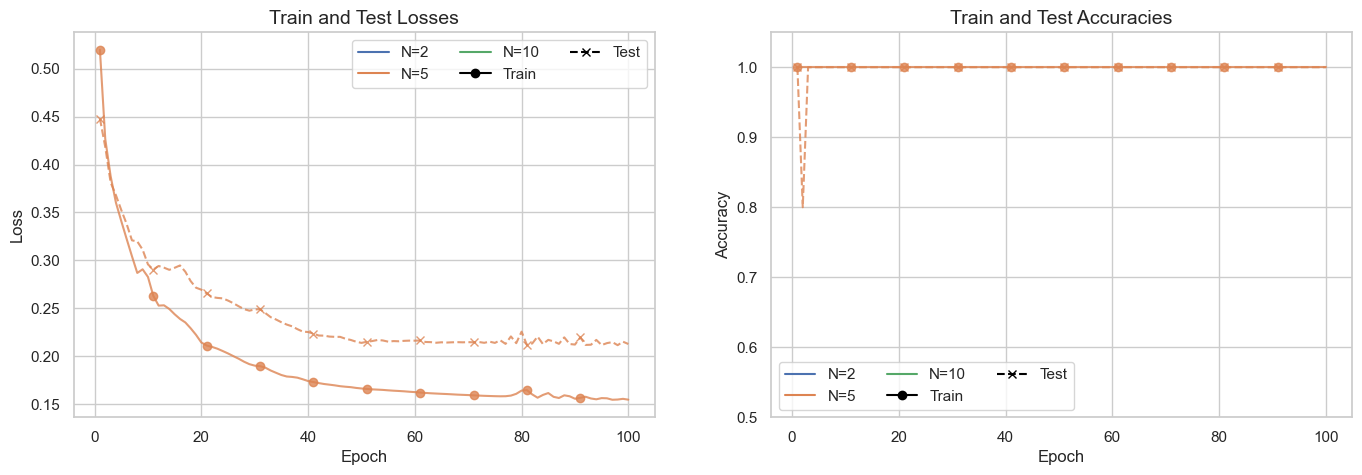

In [12]:
# ********************************************
#     PLOTTING AGGREGATED TRAINING RESULTS
# ********************************************

# Plot aggregated training results:
TrainQC.plot_aggregated_results(results_df, n_train, steps=n_epochs, 
                                  title_loss='Train and Test Losses', 
                                  title_accuracy='Train and Test Accuracies', 
                                  markevery=10)

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CODE TESTING / VALIDATION</span>

In [13]:
### ***** DATA (FOR POTENTIAL FUTURE IMPLEMENTATION) *****:
# x_train, y_train, x_test, y_test = load_moments(n_train, n_test, rng) # Loading moments
# x_train, y_train, x_test, y_test = load_IC_data(n_train, n_test, rng) # Loading IC data

In [14]:
### ***** TESTING RNG TYPES *****:

# Example usage of numpy.random.Generator
rng_test = np.random.default_rng()
print(f"Type of rng: {type(rng_test)}")

# Example usage of jax.random.PRNGKey
rng_jax_test = jax.random.PRNGKey(0)
print(f"Type of rng_jax: {type(rng_jax_test)}")

Type of rng: <class 'numpy.random._generator.Generator'>
Type of rng_jax: <class 'jaxlib.xla_extension.ArrayImpl'>


***